# DL_comp3_全_model

## Member

- 邱煒甯, 108072244
- 劉祥暉, 109072142
- 簡佩如, 112065525
- 陳凱揚, 108032053

## 1. Load data

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import tensorflow_hub as hub
from transformers import TFAutoModel, TFBertTokenizer, AutoTokenizer
from tf_sentence_transformers import SentenceTransformer
import tensorflow_text
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio
import moviepy.editor as mpy
import cv2
from IPython.display import display, Image
import time
import random

import os 
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '0'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'

2023-12-22 07:50:20.465829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 07:50:20.465888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 07:50:20.467232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 07:50:20.475245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/dist-packages/tenso

In [2]:
TRAIN_PKL_FILE = './dataset/text2ImgData.pkl'
TEST_PKL_FILE = './dataset/testData.pkl'
ID_2_STR_FILE = './dictionary/id2Word.npy'
IMAGE_SIZE = 64
BATCH_SIZE = 32
BUFFER_SIZE = 5000

Z_DIM = 128
EMB_DIM = 768
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_CAP_PER_IMG = 3

LEARNING_RATE = 1e-4
LAMBDA = 10
EPOCHS = 500
EPOCHS_PER_CKPT = 5
N_CRITIC = 3

SAMPLE_ROW = 3
SAMPLE_COL = 4
SAMPLE_NUM = SAMPLE_ROW * SAMPLE_COL
SAMPLE_DURATION = 10

In [3]:
test_cap = [
    'flower with white long white petals and very long purple stamen ',
    'this medium white flower has rows of thin blue petals and thick stamen ',
    'this flower is white and purple in color with petals that are oval shaped ',
    'this flower is pink and yellow in color with petals that are oval shaped ',
    'the flower has a large bright orange petal with pink anther ',
    'the flower shown has a smooth white petal with patches of yellow as well ',
    'white petals that become yellow as they go to the center where there is an orange stamen ',
    'this flower has bright red petals with green pedicel as its main features ',
    'this flower has the overlapping yellow petals arranged closely toward the center ',
    'this flower has green sepals surrounding several layers of slightly ruffled pink petals ',
    'the pedicel on this flower is purple with a green sepal and rose colored petals ',
    'this white flower has connected circular petals with yellow stamen ',
    'the flower has yellow petals overlapping each other and are yellow in color ',
    'this flower has numerous stamen ringed by multiple layers of thin pink petals ',
    'the petals are broad but thin at the edges with purple tints at the edges and white in the middle ',
    'the yellow flower has petals that are soft smooth and arranged in two layers below the bunch of stamen ',
    'this flower has petals that are pink and yellow with yellow stamen ',
    'red stacked petals surround yellow stamen and a black pistil ',
    'the petals of the flower are in multiple layers and are pink in yellow in color ',
    'this flower has a yellow center and layers of peach colored petals with pointed tips ',
    'this bright pink flower has several fluttery petals and a tubular center ',
    'this flower is white and yellow in color with petals that are rounded at the endges ',
    'the flower has a several pieces of yellow colored petals that looks similar to its leaves ',
    'this flower has several light pink petals and yellow anthers ',
    'this flower is yellow and white in color with petals that are star shaped near the cener ',
    'lavender and white pedal and yellow small flower in the middle of the pedals ',
    'this flower has lavender petals with maroon stripes and brown anther filaments ',
    'this flower has six plain pale yellow petals that alternate with three dark yellow speckled petals ',
    'this flower has petals that are yellow with orange lines ',
    'the flower has petals that are orange with yellow stamen ',
    'this flower has a brown center surrounded by layers of long yellow petals with rounded tips ',
    'this flower is lavender in color with petals that are ruffled and wavy ',
    'this flower is blue in color with petals that have veins ',
    'the petals on this flower are white with yellow stamen ',
    'this flower has petals that are cone shaped and dark purple ',
    'this flower is purple and white in color and has petals that are multi colored ',
    'a large group of bells that are blue on this flower ',
    'this flower is bright purple with many pedals that are roundish whth pale white outer petals ',
    'this flower has large yellow petals and long yellow stamen on it ',
    'this flower has spiky blue petals and a spiky black stigma on it ',
    'this flower is purple and yellow in color with petals that are oval shaped ',
    'the flower has petals that are large and pink with yellow anther',
]

In [4]:
# Utility function
id2word_dict = dict(np.load(ID_2_STR_FILE))

def caption2str(caption):
    return ' '.join(id2word_dict[str(i)] \
                    for i in caption \
                    if str(i) in id2word_dict and id2word_dict[str(i)][0] != '<')

def generate_img(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), dtype=np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None: 
        imageio.imwrite(path, out)
    return out
  
def generate_gif(imgs_path_list, fname, duration):
    imgs = []
    for img_path in imgs_path_list:
        img = imageio.imread(img_path)
        img_id = img_path.split('/')[-1].split('.')[0]
        
        img_with_id = imageio.core.util.Array(np.concatenate([np.ones((20, img.shape[1], 3), dtype=np.uint8) * 255, img], axis=0))
        img_with_id[:20, :, :] = 0
        img_with_id[:20, :, 0] = 255
        img_with_id[:20, :, 1] = 255
        img_with_id[:20, :, 2] = 255
        img_with_id[:20, :, :] = cv2.putText(img_with_id[:20, :, :], f'EPOCH: {img_id}', (10, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        
        imgs.append(img_with_id)
        
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t: imgs[int(n * t)], duration=duration)
    clip.write_gif(fname, fps=n)

In [5]:
class TFSentenceTransformer(keras.layers.Layer):
    def __init__(self, model_name):
        super().__init__()
        self.model = TFAutoModel.from_pretrained(model_name)

    def call(self, inputs, normalize=True):
        model_output = self.model(inputs)
        embeddings = self.mean_pooling(model_output, inputs['attention_mask'])
        if normalize:
            embeddings = self.normalize(embeddings)
        return embeddings

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = tf.cast(
            tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
            tf.float32
        )
        return tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1) \
                / tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)

    def normalize(self, embeddings):
        embeddings, _ = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings


class E2ESentenceTransformer(keras.Model):
    def __init__(self, model_name):
        super().__init__(name='text_encoder')
#         self.tokenizer = TFBertTokenizer.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = TFSentenceTransformer(model_name)

    def call(self, inputs):
#         tokenized = self.tokenizer(inputs)
        tokenized = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
        return self.model(tokenized)
    

# model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model_name = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
text_encoder = E2ESentenceTransformer(model_name)

2023-12-22 07:50:32.160535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31150 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0
All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at sentence-transformers/paraphrase-multilingual-mpnet-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Num steps: 6609


2023-12-22 03:57:19.775591: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8818002100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-22 03:57:19.775619: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1703188639.785882    1419 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-12-22 03:57:19.786458: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2023-12-22 03:57:19.786554: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2023-12-22 03:57:19.786749: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2023-12-22 03:57:19.845441: E external/local_xla/xla/stream_executor/stream_executor_interna

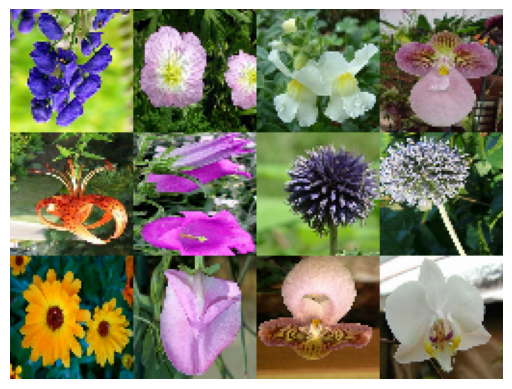

In [6]:
def preprocess_data(image_path, caption):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    img = tf.cast(img, tf.float32)
    
    # data augmentation
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.04)
    img = tf.image.resize(img, (IMAGE_SIZE + IMAGE_SIZE // 10, IMAGE_SIZE + IMAGE_SIZE // 10))
    img = tf.image.random_crop(img, (IMAGE_SIZE, IMAGE_SIZE, 3))
    
    img = (img / 255) * 2 - 1
    caption = tf.cast(caption, tf.float32)
    return img, caption

def dataset_generator(pkl_file):
    df = pd.read_pickle(pkl_file)
    captions = df['Captions'].values
    image_paths = df['ImagePath'].values
    
    caption = []
    image_path = []
    for i, caps in enumerate(captions):
        for cap in caps:
            caption.append(cap)
            image_path.append(image_paths[i])
            
    caption = np.asarray(caption)
    caption = caption.astype(np.int32)
    caption = [caption2str(cap) for cap in caption]
    caption = tf.concat(
        [text_encoder(caption[64 * i:64 * min(len(caption), i + 1)]) \
             for i in range((len(caption) + 63) // 64)], 
        axis=0)
    caption = caption.numpy()
    caption = np.asarray(caption)
    caption = np.concatenate([caption] * NUM_CAP_PER_IMG, axis=0)
    image_path = np.concatenate([image_path] * NUM_CAP_PER_IMG, axis=0)
    
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((image_path, caption))
    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

# random.seed(0)
dataset = dataset_generator(TRAIN_PKL_FILE)
num_steps = len(dataset)
print(f'Num steps: {num_steps}')

imgs, caps = next(iter(dataset))

# Show caption
# caps = caps[:SAMPLE_NUM].numpy()
# for idx, cap in enumerate(caps):
#     i, j = divmod(idx, SAMPLE_COL)
#     print(f'({i+1},{j+1}): {cap}')
    
# Show image
imgs = tf.clip_by_value((imgs[:SAMPLE_NUM] + 1) / 2 * 255, 0, 255)
img = generate_img(imgs, SAMPLE_ROW, SAMPLE_COL)
plt.imshow(img)
plt.axis("off")
plt.show()

## 2. Define model

In [6]:
class Generator(keras.Model):
    def __init__(self, input_z_shape, emb_shape):
        super().__init__(name='generator')
        self.input_z_shape = input_z_shape
        self.emb_shape = emb_shape
        self.text = keras.Sequential([
            keras.layers.Flatten(), 
            keras.layers.Dense(384), 
            keras.layers.BatchNormalization(), 
            keras.layers.LeakyReLU(), 
        ])
        self.generator = keras.Sequential([
            keras.layers.Dense(8192, use_bias=False), 
            keras.layers.Reshape((4, 4, 512)), 
    
            keras.layers.Conv2DTranspose(
                512, 
                (4, 4), 
                strides=(1, 1), 
                padding='same', 
                use_bias=False, 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
            keras.layers.BatchNormalization(), 
            keras.layers.LeakyReLU(), 

            keras.layers.Conv2DTranspose(
                256, 
                (4, 4), 
                strides=(2, 2), 
                padding='same', 
                use_bias=False, 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
            keras.layers.BatchNormalization(), 
            keras.layers.LeakyReLU(), 
            keras.layers.Conv2DTranspose(
                128, 
                (4, 4), 
                strides=(2, 2), 
                padding='same', 
                use_bias=False, 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
            keras.layers.BatchNormalization(), 
            keras.layers.LeakyReLU(), 

            keras.layers.Conv2DTranspose(
                64, 
                (4, 4), 
                strides=(2, 2), 
                padding='same', 
                use_bias=False, 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
            keras.layers.BatchNormalization(), 
            keras.layers.LeakyReLU(), 

            keras.layers.Conv2DTranspose(
                3, 
                (4, 4), 
                strides=(2, 2), 
                padding='same', 
                use_bias=False, 
                activation='tanh', 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
        ])
        
    def call(self, text, noise_z):
        text = self.text(text)
        text_concat = tf.concat([noise_z, text], axis=1)
        output = self.generator(text_concat)
        return output

    def summary(self):
        text = keras.layers.Input(shape=(self.emb_shape, ), name='text')
        noise_z = keras.layers.Input(shape=(self.input_z_shape, ), name='noise_z')
        model = keras.Model(name='generator', inputs=[text, noise_z], outputs=self.call(text, noise_z))
        return model.summary()

generator = Generator(Z_DIM, EMB_DIM)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None, 768)]                0         []                            
                                                                                                  
 noise_z (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 sequential (Sequential)     (None, 384)                  296832    ['text[0][0]']                
                                                                                                  
 tf.concat (TFOpLambda)      (None, 512)                  0         ['noise_z[0][0]',             
                                                                     'sequential[0][0]']  

In [7]:
class Discriminator(keras.Model):
    def __init__(self, input_x_shape, emb_shape):
        super().__init__(name='generator')
        self.input_x_shape = input_x_shape
        self.emb_shape = emb_shape
        self.text = keras.Sequential([
            keras.layers.Flatten(), 
            keras.layers.Dense(384), 
            keras.layers.BatchNormalization(), 
            keras.layers.LeakyReLU(), 
        ])
        self.image = keras.Sequential([
            keras.layers.Conv2D(
                64, 
                (4, 4), 
                strides=(2, 2), 
                padding='same', 
                use_bias=False, 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
            keras.layers.LeakyReLU(), 

            keras.layers.Conv2D(
                128, 
                (4, 4), 
                strides=(2, 2), 
                padding='same', 
                use_bias=False, 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
            keras.layers.LeakyReLU(), 

            keras.layers.Conv2D(
                256, 
                (4, 4), 
                strides=(2, 2), 
                padding='same', 
                use_bias=False, 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
            keras.layers.LeakyReLU(), 
            keras.layers.Conv2D(
                512, 
                (4, 4), 
                strides=(2, 2), 
                padding='same', 
                use_bias=False, 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
            keras.layers.LeakyReLU(), 
        ])
        self.discriminator = keras.Sequential([
            keras.layers.Conv2D(
                512, 
                (1, 1), 
                strides=(1, 1), 
                padding='same', 
                use_bias=False, 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
            keras.layers.LeakyReLU(),
            
            keras.layers.Conv2D(
                1, 
                (4, 4), 
                strides=(1, 1), 
                padding='same', 
                use_bias=False, 
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
            ), 
            keras.layers.Flatten(), 
            keras.layers.Dense(1), 
        ])
        
    def call(self, text, img):
        text = self.text(text)
        text = tf.reshape(text, shape=(-1, 4, 4, text.shape[-1] // 16))
        img = self.image(img)
        text_concat = tf.concat([img, text], axis=3)
        output = self.discriminator(text_concat)
        return output

    def summary(self):
        text = keras.layers.Input(shape=(self.emb_shape, ), name='text')
        img = keras.layers.Input(shape=self.input_x_shape, name='img')
        model = keras.Model(name='discriminator', inputs=[text, img], outputs=self.call(text, img))
        return model.summary()

discriminator = Discriminator(IMAGE_SHAPE, EMB_DIM)
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None, 768)]                0         []                            
                                                                                                  
 img (InputLayer)            [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 384)                  296832    ['text[0][0]']                
                                                                                                  
 sequential_3 (Sequential)   (None, 4, 4, 512)            2755584   ['img[0][0]']                 
                                                                                      

In [8]:
optimizer_g = keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5)
optimizer_d = keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5)

In [9]:
checkpoint_path = './ckpt-bert3'

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           optimizer_g=optimizer_g,
                           optimizer_d=optimizer_d)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

start_epoch = 1
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_ckpt = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    start_epoch = EPOCHS_PER_CKPT * latest_ckpt + 1
    print(f'Restore from latest checkpoint: {ckpt_manager.latest_checkpoint.split("/")[-1]}')
    
print(f'Start epoch: {start_epoch}')

Restore from latest checkpoint: ckpt-59
Start epoch: 296


## 3. Training

In [11]:
loss_x_list = []
loss_g_list = []
loss_d_list = []

In [12]:
@tf.function
def train_step_g(real_img, caption):
    input_g = tf.random.normal([BATCH_SIZE, Z_DIM])
    text = caption
    
    with tf.GradientTape() as tape_g:
        fake_img = generator(text, input_g, training=True)
        fake_pred = discriminator(text, fake_img, training=True)
        loss_g = -tf.reduce_mean(fake_pred)
        
    gradient_g = tape_g.gradient(loss_g, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(gradient_g, generator.trainable_variables))
    
    return loss_g
    
@tf.function
def train_step_d(real_img, caption):
    input_g = tf.random.normal([BATCH_SIZE, Z_DIM])
    text = caption
    epsilon = tf.random.uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0, maxval=1)
    
    with tf.GradientTape() as tape_d:
        with tf.GradientTape() as tape_gp:
            fake_img = generator(text, input_g, training=True)
            fake_img_gp = epsilon * real_img + (1 - epsilon) * fake_img
            fake_pred_gp = discriminator(text, fake_img_gp, training=True)
        
        gradient_gp = tape_gp.gradient(fake_pred_gp, fake_img_gp)
        gradient_norm_gp = tf.sqrt(tf.reduce_sum(tf.square(gradient_gp), axis=np.arange(1, len(gradient_gp.shape))))
        gradient_penalty = tf.reduce_mean(tf.square(gradient_norm_gp - 1))
        
        fake_pred = discriminator(text, fake_img, training=True)
        real_pred = discriminator(text, real_img, training=True)
        
        loss_d = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    
    gradient_d = tape_d.gradient(loss_d, discriminator.trainable_variables)
    optimizer_d.apply_gradients(zip(gradient_d, discriminator.trainable_variables))
    
    return loss_d

  0%|          | 0/6609 [00:00<?, ?it/s]2023-12-22 03:58:17.788319: I external/local_xla/xla/service/service.cc:168] XLA service 0x564c15c976c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-22 03:58:17.788379: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-12-22 03:58:17.805380: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
W0000 00:00:1703188698.032180    1354 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2023-12-22 03:58:18.049636: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1703188701.584491    1354 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
100%|██████████| 6609/6609 [04:17<00:00, 25.67it/s]


Epoch 241: Loss_g 14.57701, Loss_d -4.53355


100%|██████████| 6609/6609 [04:14<00:00, 26.01it/s]


Epoch 242: Loss_g 13.46318, Loss_d -5.19645


100%|██████████| 6609/6609 [04:13<00:00, 26.07it/s]


Epoch 243: Loss_g 18.17735, Loss_d -4.25783


100%|██████████| 6609/6609 [04:06<00:00, 26.77it/s]


Epoch 244: Loss_g 8.21514, Loss_d -4.14011


 79%|███████▉  | 5206/6609 [03:21<00:52, 26.85it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 6609/6609 [04:00<00:00, 27.46it/s]


Epoch 248: Loss_g 16.86644, Loss_d -3.53371


100%|██████████| 6609/6609 [03:58<00:00, 27.74it/s]


Epoch 249: Loss_g 7.18686, Loss_d -4.64617


 34%|███▎      | 2226/6609 [01:29<02:43, 26.84it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 6609/6609 [04:01<00:00, 27.36it/s]


Epoch 252: Loss_g 12.32525, Loss_d -4.58856


100%|██████████| 6609/6609 [03:51<00:00, 28.49it/s]


Epoch 253: Loss_g 2.16556, Loss_d -5.16808


100%|██████████| 6609/6609 [03:47<00:00, 29.08it/s]


Epoch 254: Loss_g 16.12473, Loss_d -5.27799


100%|██████████| 6609/6609 [04:00<00:00, 27.47it/s]


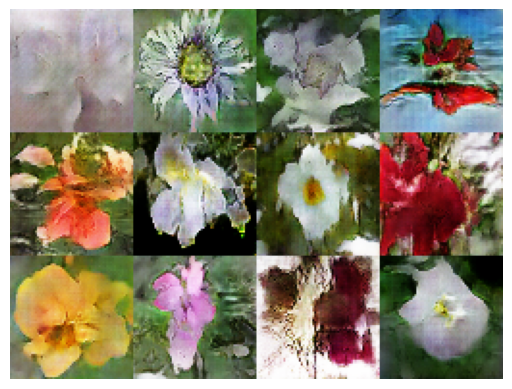

Epoch 255: Loss_g 4.49619, Loss_d -5.05850


100%|██████████| 6609/6609 [03:58<00:00, 27.76it/s]


Epoch 256: Loss_g 20.17846, Loss_d -5.45371


100%|██████████| 6609/6609 [04:01<00:00, 27.34it/s]


Epoch 257: Loss_g 16.78196, Loss_d -4.43237


100%|██████████| 6609/6609 [04:01<00:00, 27.39it/s]


Epoch 258: Loss_g 9.07813, Loss_d -4.02484


100%|██████████| 6609/6609 [04:01<00:00, 27.32it/s]


Epoch 259: Loss_g 12.75010, Loss_d -4.54178


100%|██████████| 6609/6609 [03:37<00:00, 30.33it/s]


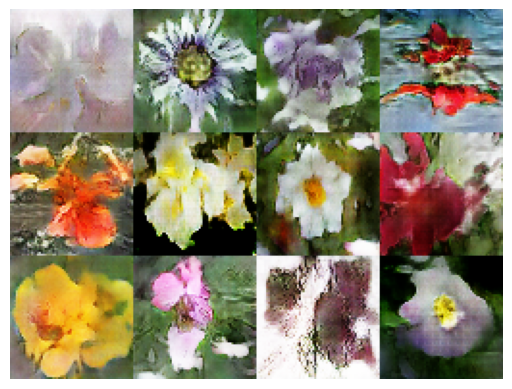

Epoch 260: Loss_g 7.78893, Loss_d -5.21480


100%|██████████| 6609/6609 [04:05<00:00, 26.89it/s]


Epoch 261: Loss_g 17.57680, Loss_d -5.32976


100%|██████████| 6609/6609 [03:55<00:00, 28.11it/s]


Epoch 262: Loss_g 9.85085, Loss_d -4.79598


100%|██████████| 6609/6609 [04:02<00:00, 27.26it/s]


Epoch 263: Loss_g 7.93743, Loss_d -4.46250


100%|██████████| 6609/6609 [04:02<00:00, 27.22it/s]


Epoch 264: Loss_g 13.95585, Loss_d -4.95109


100%|██████████| 6609/6609 [04:06<00:00, 26.83it/s]


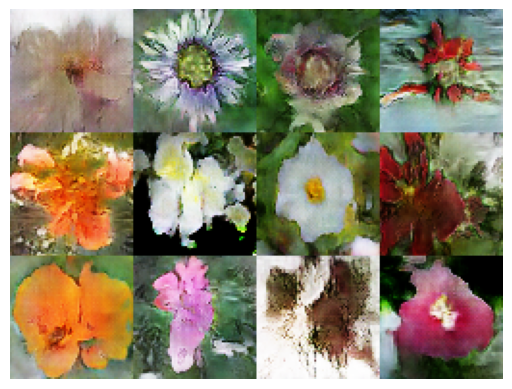

Epoch 265: Loss_g 13.29846, Loss_d -4.50470


100%|██████████| 6609/6609 [04:03<00:00, 27.13it/s]


Epoch 266: Loss_g 6.48312, Loss_d -5.07092


100%|██████████| 6609/6609 [04:04<00:00, 27.04it/s]


Epoch 267: Loss_g 8.03212, Loss_d -3.67992


 75%|███████▌  | 4985/6609 [02:53<00:56, 28.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 6609/6609 [03:54<00:00, 28.21it/s]


Epoch 276: Loss_g 13.55878, Loss_d -3.81920


100%|██████████| 6609/6609 [04:08<00:00, 26.64it/s]


Epoch 281: Loss_g 9.25944, Loss_d -4.23441


 45%|████▍     | 2942/6609 [01:54<02:34, 23.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 6609/6609 [03:55<00:00, 28.04it/s]


Epoch 284: Loss_g 2.64294, Loss_d -4.72150


100%|██████████| 6609/6609 [04:08<00:00, 26.56it/s]


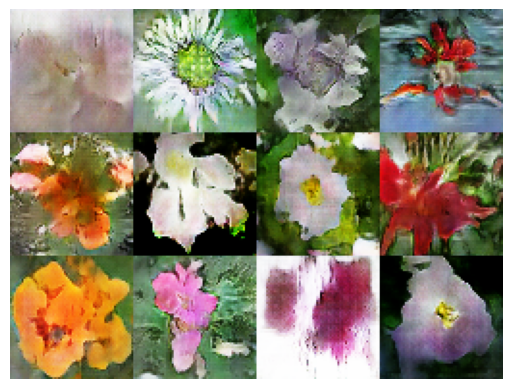

Epoch 285: Loss_g 4.08116, Loss_d -4.07641


100%|██████████| 6609/6609 [04:01<00:00, 27.33it/s]


Epoch 286: Loss_g 12.74280, Loss_d -5.28873


  4%|▎         | 241/6609 [00:14<03:56, 26.92it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 6609/6609 [03:54<00:00, 28.22it/s]


Epoch 289: Loss_g 6.38460, Loss_d -4.40980


100%|██████████| 6609/6609 [04:07<00:00, 26.71it/s]


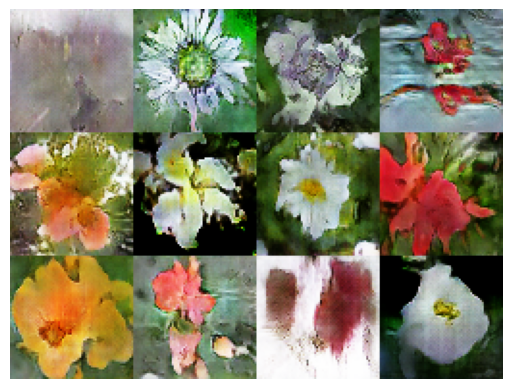

Epoch 290: Loss_g 14.50901, Loss_d -4.12756


  1%|▏         | 99/6609 [00:08<03:43, 29.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 6609/6609 [03:59<00:00, 27.63it/s]


Epoch 293: Loss_g 15.12807, Loss_d -4.83868


100%|██████████| 6609/6609 [04:07<00:00, 26.71it/s]


Epoch 294: Loss_g 8.17071, Loss_d -5.20651


 68%|██████▊   | 4523/6609 [02:43<01:10, 29.46it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 58%|█████▊    | 3845/6609 [02:22<01:36, 28.78it/s]

In [ ]:
start = time.time()

sample_z = tf.random.normal([SAMPLE_NUM, Z_DIM])
sample_cap = test_cap[:SAMPLE_NUM]

for epoch in range(start_epoch, EPOCHS + 1):
    
    loss_g = 0
    loss_d = 0
    
    # Train step
    for step, (img, cap) in tqdm(enumerate(dataset), total=num_steps):
        if step % (N_CRITIC + 1) == N_CRITIC - 1:
            loss_g += train_step_g(img, cap)
            # Store data to list
            loss_x_list.append(epoch + step / num_steps)
            loss_g_list.append(loss_g / 1)
            loss_d_list.append(loss_d / N_CRITIC)
            loss_g = 0
            loss_d = 0
        else:
            loss_d += train_step_d(img, cap)
    
    # Save checkpoint
    if epoch % EPOCHS_PER_CKPT == 0:
        ckpt_manager.save()
    
    # Generate sample image
    sample_text = text_encoder(sample_cap)
    sample_imgs = generator(sample_text, sample_z, training=False)
    sample_imgs = tf.clip_by_value((sample_imgs + 1) / 2 * 255, 0, 255)
    img = generate_img(sample_imgs, SAMPLE_ROW, SAMPLE_COL, f'imgs/{epoch:>04d}.png')
    
    # Display sample image
    if epoch % 5 == 0:
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    
    print(f'Epoch {epoch}: Loss_g {loss_g_list[-1]:.5f}, Loss_d {loss_d_list[-1]:.5f}')
    
print (f'Time taken for {EPOCHS} epoch: {time.time() - start} sec')

## 4. Testing

In [10]:
def test_preprocess_data(index, caption):
    caption = tf.cast(caption, tf.float32)
    return index, caption

def test_dataset_generator(pkl_file):
    df = pd.read_pickle(pkl_file)
    captions = df['Captions'].values
    caption = np.asarray(captions)
#     caption = caption.astype(np.int32)
    caption = [caption2str(x) for x in caption]
    caption = tf.concat(
        [text_encoder(caption[64 * i:64 * min(len(caption), i + 1)]) \
             for i in range((len(caption) + 63) // 64)], 
        axis=0)
    caption = caption.numpy()
    caption = np.asarray(caption)
    index = df['ID'].values
    index = np.asarray(index)
    
    assert caption.shape[0] == index.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((index, caption))
    dataset = dataset.map(test_preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(BATCH_SIZE, drop_remainder=True)
    
    return dataset

test_dataset = test_dataset_generator(TEST_PKL_FILE)

data = pd.read_pickle(TEST_PKL_FILE)
captions = data['Captions'].values
NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / BATCH_SIZE)

In [11]:
@tf.function
def test_step(caption):
    input_g = tf.random.normal([BATCH_SIZE, Z_DIM])
    text = caption
    fake_img = generator(text, input_g, training=False)
    return fake_img

In [12]:
output_dir = './inference/demo'

def inference(dataset):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    step = 0
    start = time.time()
    for idx, captions in dataset:
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions)
        step += 1
        for i in range(BATCH_SIZE):
            img = np.clip(fake_image[i].numpy() * 0.5 + 0.5, 0.0, 1.0)
            plt.imsave(output_dir + '/inference_{:04d}.jpg'.format(idx[i]), img)
            
    print('Time for inference is {:.4f} sec'.format(time.time() - start))

In [13]:
inference(test_dataset)

2023-12-22 07:51:42.694883: I external/local_xla/xla/service/service.cc:168] XLA service 0x5594a27edc50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-22 07:51:42.694939: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-12-22 07:51:42.703803: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-22 07:51:42.734064: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1703202703.971236    2129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1703202703.991271    2129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Time for inference is 2.8059 sec


## 5. Result

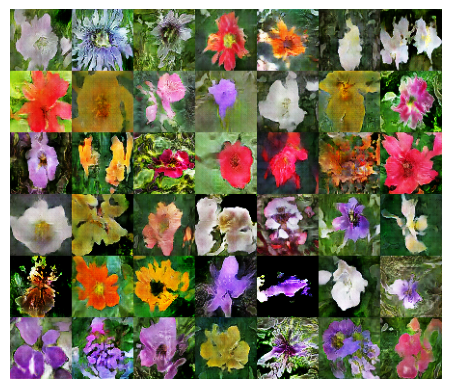

In [14]:
sample_z = tf.random.normal([42, Z_DIM])
sample_cap = test_cap[:42]

sample_text = text_encoder(sample_cap)
sample_imgs = generator(sample_text, sample_z, training=False)
sample_imgs = tf.clip_by_value((sample_imgs + 1) / 2 * 255, 0, 255)
img = generate_img(sample_imgs, 6, 7, f'sample.png')

plt.imshow(img)
plt.axis("off")
plt.show()

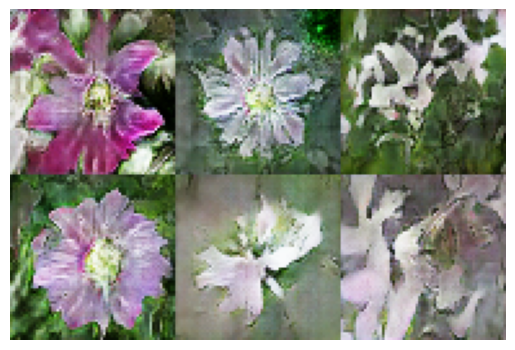

In [15]:
cap = 'flower with white long white petals and very long purple stamen '
sample_z = tf.random.normal([6, Z_DIM])
sample_cap = [cap] * 6

sample_text = text_encoder(sample_cap)
sample_imgs = generator(sample_text, sample_z, training=False)
sample_imgs = tf.clip_by_value((sample_imgs + 1) / 2 * 255, 0, 255)
img = generate_img(sample_imgs, 2, 3, f'sample.png')

plt.imshow(img)
plt.axis("off")
plt.show()